In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Suppress warnings
warnings.filterwarnings('ignore')

# Add current directory to path
sys.path.insert(0, os.getcwd())

# Import necessary modules
from main import main
from service.data_setup import load_train_csv, split_train_validation
from service.preprocessing.cleansing import fill_missing_values
from service.preprocessing.featureExtraction import *
from service.preprocessing.encoding import one_hot_encode_and_align, drop_original_columns
from service.modeling.training import train_xgb_classifier


In [2]:
# 데이터 로드 및 전처리
print("=== 피처 중요도 분석을 위한 모델 학습 ===")

# 1. 데이터 로드
data_dir = os.path.join('data')
train_path = os.path.join(data_dir, 'hotel_bookings_train.csv')

print(f"Train 데이터 로드: {train_path}")
X, y = load_train_csv(train_path)
print(f"전체 데이터 형태: {X.shape}")

# 2. 결측치 처리
X = fill_missing_values(X)

# 3. Train/Validation 분할
X_tr, X_val, y_tr, y_val = split_train_validation(X, y, random_state=42)
print(f"Train: {X_tr.shape}, Validation: {X_val.shape}")


=== 피처 중요도 분석을 위한 모델 학습 ===
Train 데이터 로드: data\hotel_bookings_train.csv
전체 데이터 형태: (31331, 32)
Train: (25064, 32), Validation: (6267, 32)


In [3]:
# 4. 피처 엔지니어링 적용 (main.py와 동일한 순서)
print("피처 엔지니어링 수행 중...")

# featureExtraction.py에서 정의된 모든 피처들 적용
X_tr, X_val = add_total_guests_and_is_alone(X_tr, X_val)
X_tr, X_val = add_has_company(X_tr, X_val)  
X_tr, X_val = add_is_FB_meal(X_tr, X_val)
X_tr, X_val = process_adr_iqr(X_tr, X_val)
X_tr, X_val = add_total_stay(X_tr, X_val)
X_tr, X_val = process_lead_time(X_tr, X_val)
X_tr, X_val = map_hotel_type(X_tr, X_val)

# 5. 불필요한 컬럼 드롭 및 원-핫 인코딩
X_tr, X_val = drop_original_columns(X_tr, X_val)
X_tr, X_val = one_hot_encode_and_align(X_tr, X_val)

print(f"최종 피처 수: {X_tr.shape[1]}")
print("피처 엔지니어링 완료!")


피처 엔지니어링 수행 중...
최종 피처 수: 43
피처 엔지니어링 완료!


In [4]:
# 6. XGBoost 모델 학습
print("XGBoost 모델 학습 중...")
model = train_xgb_classifier(X_tr, y_tr, random_state=42)
print("모델 학습 완료!")


XGBoost 모델 학습 중...
🎯 F1-score 최적화 완료!
   최적 임계값: 0.651
   최적 F1-score: 0.728
모델 학습 완료!


=== 피처 중요도 분석 ===


<Figure size 1200x800 with 0 Axes>

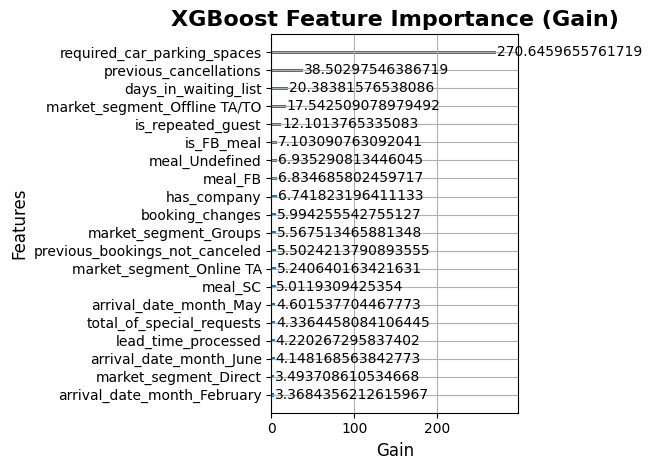

In [5]:
# 7. 피처 중요도 시각화
print("=== 피처 중요도 분석 ===")

# 피처 중요도 그래프 생성 (gain 기준)
plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title('XGBoost Feature Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Gain', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


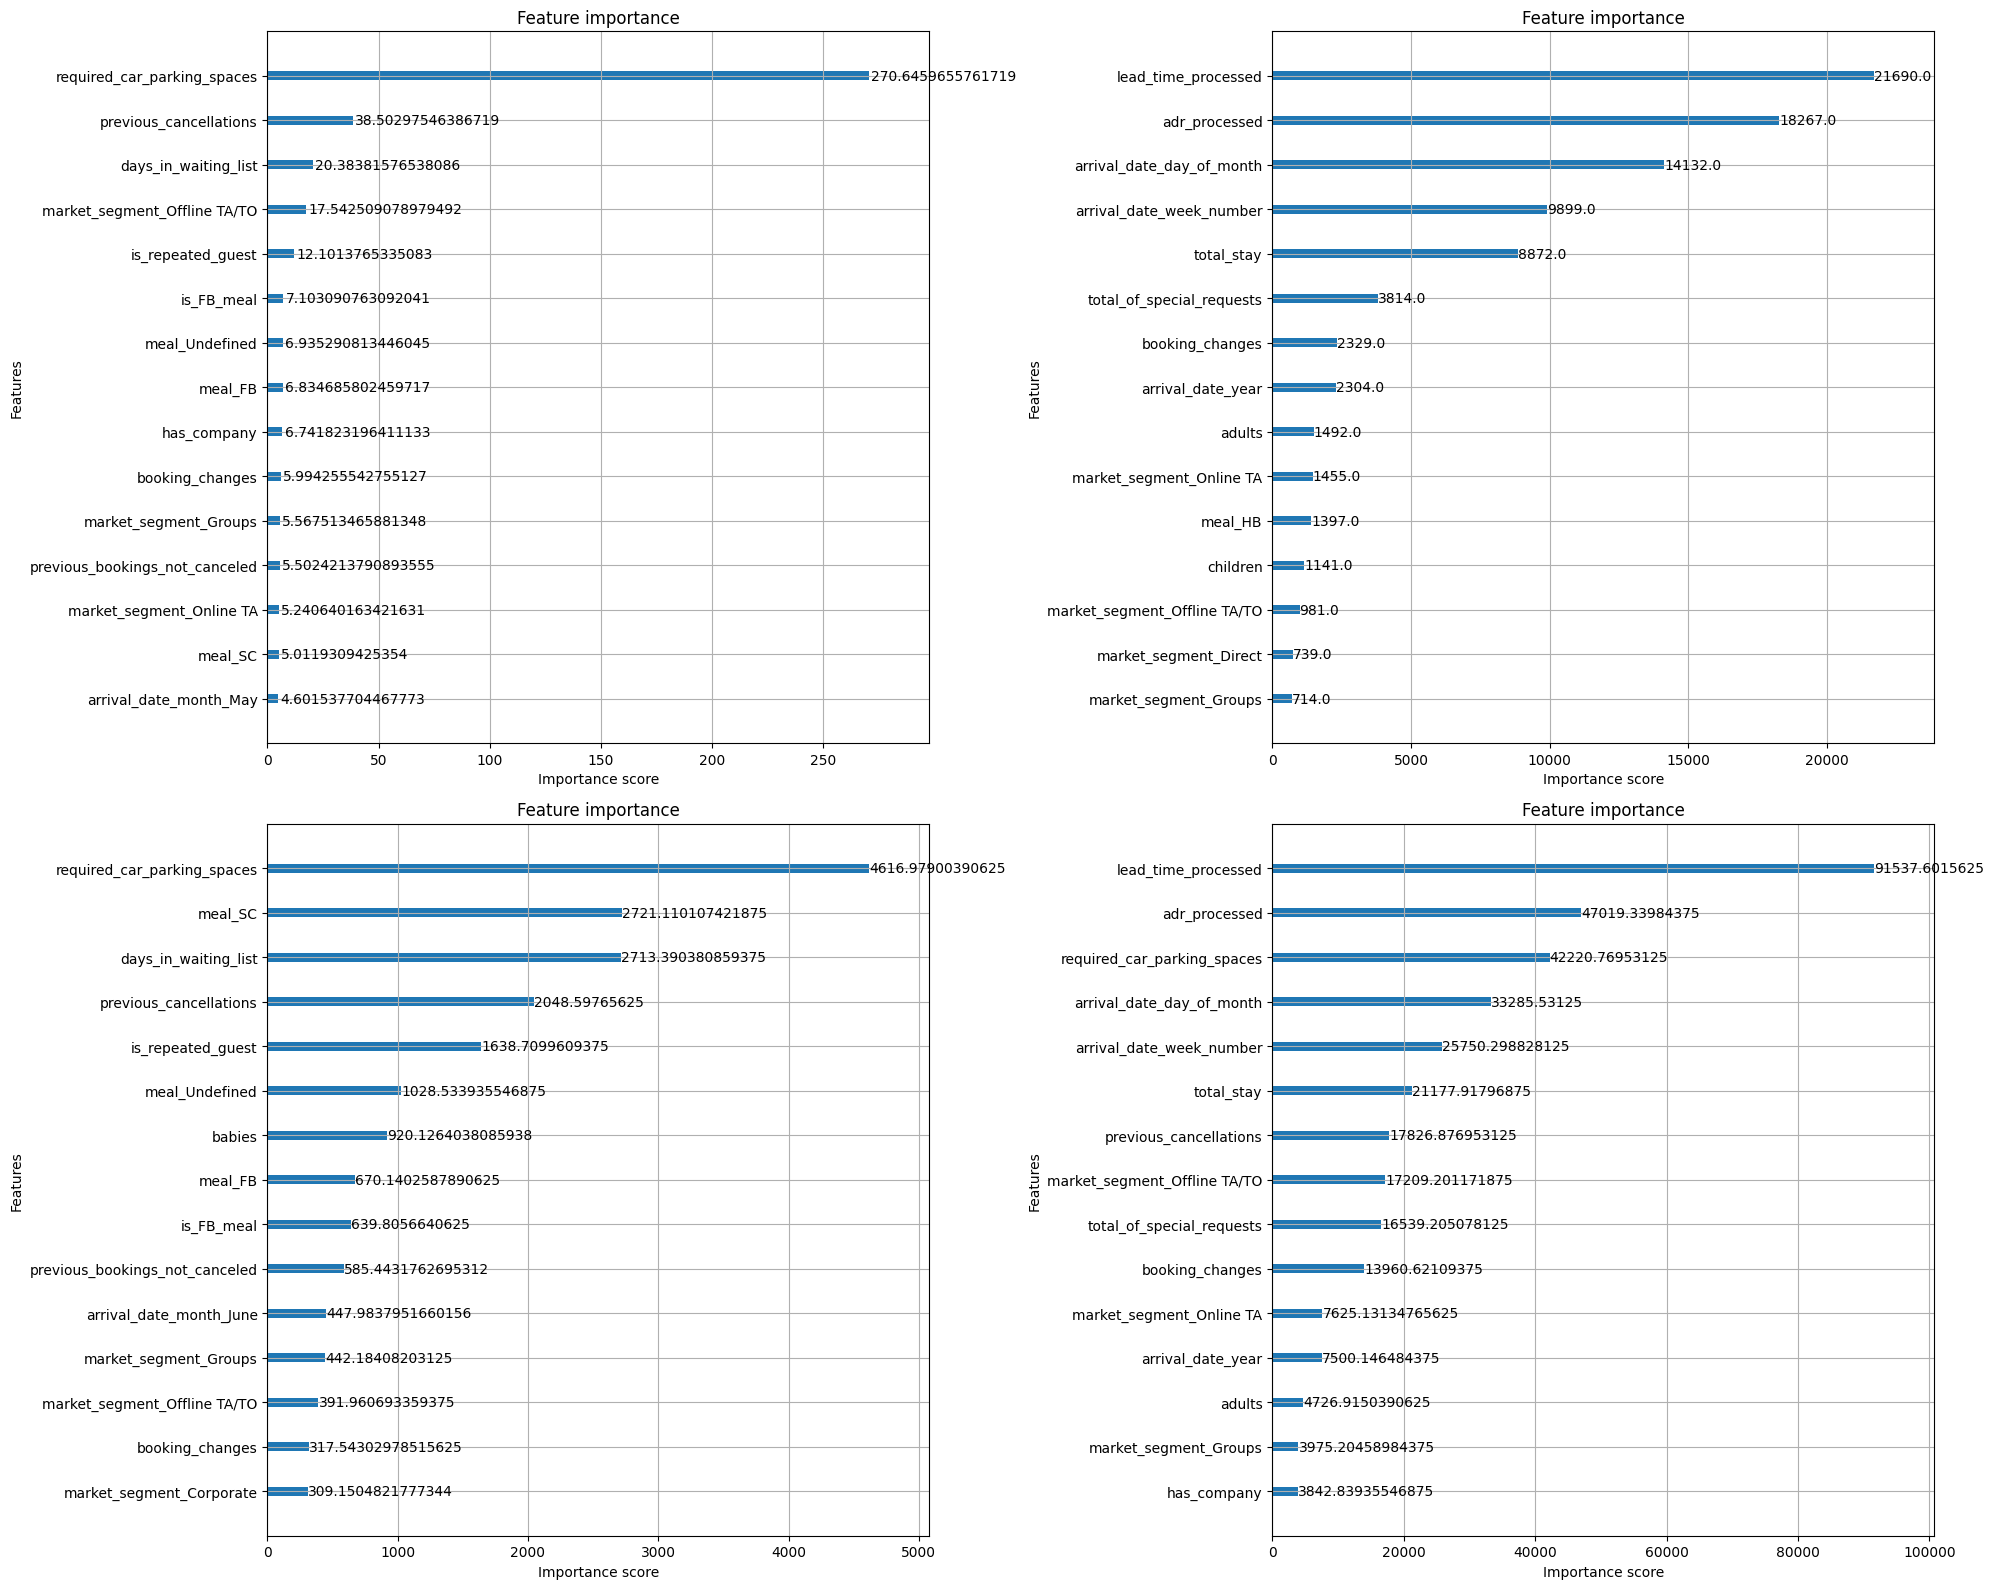

In [6]:
# 8. 추가 피처 중요도 분석 (다양한 importance_type으로)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Gain 기준
axes[0, 0].set_title('Feature Importance - Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='gain', max_num_features=15, ax=axes[0, 0])

# Weight 기준 (사용 빈도)
axes[0, 1].set_title('Feature Importance - Weight', fontsize=14, fontweight='bold')  
plot_importance(model, importance_type='weight', max_num_features=15, ax=axes[0, 1])

# Cover 기준
axes[1, 0].set_title('Feature Importance - Cover', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='cover', max_num_features=15, ax=axes[1, 0])

# Total Gain 기준
axes[1, 1].set_title('Feature Importance - Total Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='total_gain', max_num_features=15, ax=axes[1, 1])

plt.tight_layout()
plt.show()


In [7]:
# 9. 피처 중요도 상위 피처들 분석
import pandas as pd

# 피처 중요도를 DataFrame으로 정리
feature_importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), 
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)

print("=== 상위 20개 중요 피처 (Gain 기준) ===")
print(importance_df.head(20))

# featureExtraction.py에서 만든 피처들 식별
engineered_features = ['is_alone', 'has_company', 'is_FB_meal', 'adr_processed', 
                      'total_stay', 'lead_time_processed', 'is_resort']

print("\n=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===")
engineered_importance = importance_df[importance_df['feature'].isin(engineered_features)]
if not engineered_importance.empty:
    print(engineered_importance)
else:
    print("피처 엔지니어링 피처들이 상위 피처에 포함되지 않았습니다.")


=== 상위 20개 중요 피처 (Gain 기준) ===
                         feature  importance
11   required_car_parking_spaces  270.645966
7         previous_cancellations   38.502975
10          days_in_waiting_list   20.383816
37  market_segment_Offline TA/TO   17.542509
6              is_repeated_guest   12.101377
..                           ...         ...
12     total_of_special_requests    4.336446
18           lead_time_processed    4.220267
24       arrival_date_month_June    4.148169
35         market_segment_Direct    3.493709
21   arrival_date_month_February    3.368436

[20 rows x 2 columns]

=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===
                feature  importance
15           is_FB_meal    7.103091
14          has_company    6.741823
18  lead_time_processed    4.220267
13             is_alone    3.199484
16        adr_processed    2.574004
17           total_stay    2.387051


NameError: name 'df' is not defined

In [9]:
# 11. 생성한 피처들과 is_canceled 간의 관계 분석
print("=== 피처별 취소율 분석 ===")

# 원본 데이터에 타겟 변수 추가하여 분석용 DataFrame 생성
df_analysis = X_tr.copy()
df_analysis['is_canceled'] = y_tr.values

print(f"분석용 데이터 형태: {df_analysis.shape}")
print(f"전체 취소율: {df_analysis['is_canceled'].mean()*100:.2f}%")


=== 피처별 취소율 분석 ===
분석용 데이터 형태: (25064, 44)
전체 취소율: 25.71%


In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우: 맑은 고딕
plt.rc('font', family='Malgun Gothic')

# 맥: 애플고딕
# plt.rc('font', family='AppleGothic')

# 마이너스(-) 깨짐 방지
plt.rc('axes', unicode_minus=False)


In [13]:
# 12. 피처 엔지니어링으로 생성한 피처들 정의
# featureExtraction.py에서 생성한 피처들
engineered_features = {
    'is_alone': '혼자 온 고객 여부 (1명)',
    'has_company': '회사 동반 여부',
    'is_FB_meal': 'Full Board 식사 여부', 
    'adr_processed': '평균 일일 요금 (이상치 처리)',
    'total_stay': '총 숙박 일수',
    'lead_time_processed': '예약 리드타임 (이상치 처리)',
    'is_resort': '리조트 호텔 여부'
}

# 실제 데이터에 존재하는 피처만 필터링
available_features = {}
for feature, description in engineered_features.items():
    if feature in df_analysis.columns:
        available_features[feature] = description
    else:
        print(f"[경고] {feature} 피처가 데이터에 없습니다.")

print(f"\n분석 가능한 엔지니어링 피처: {len(available_features)}개")
for feature, desc in available_features.items():
    print(f"- {feature}: {desc}")



분석 가능한 엔지니어링 피처: 7개
- is_alone: 혼자 온 고객 여부 (1명)
- has_company: 회사 동반 여부
- is_FB_meal: Full Board 식사 여부
- adr_processed: 평균 일일 요금 (이상치 처리)
- total_stay: 총 숙박 일수
- lead_time_processed: 예약 리드타임 (이상치 처리)
- is_resort: 리조트 호텔 여부



=== 범주형/이진 피처 취소율 분석 ===

📊 is_alone (혼자 온 고객 여부 (1명))
   is_alone  count      mean  cancel_rate_pct
0         0  20243  0.280591        28.059082
1         1   4821  0.158681        15.868077


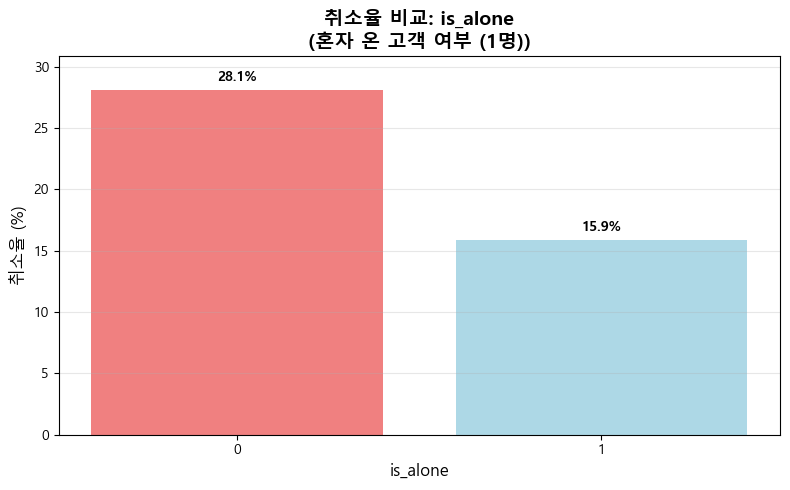


📊 has_company (회사 동반 여부)
   has_company  count      mean  cancel_rate_pct
0            0  22948  0.269392        26.939167
1            1   2116  0.124291        12.429112


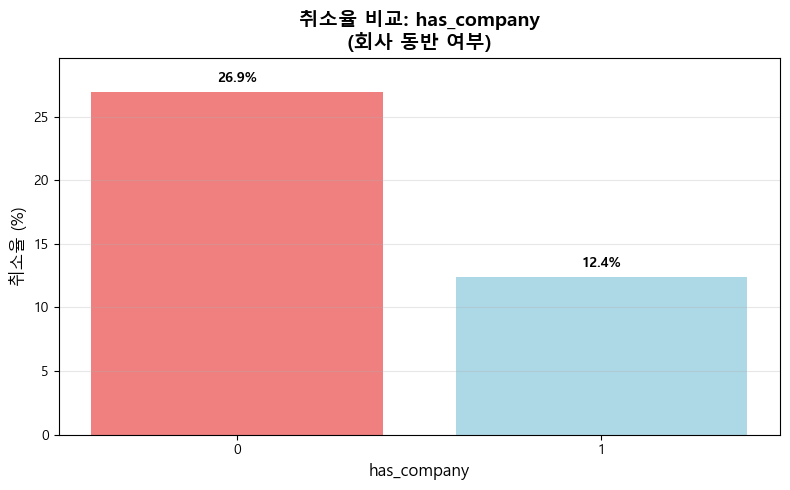


📊 is_FB_meal (Full Board 식사 여부)
   is_FB_meal  count      mean  cancel_rate_pct
0           0  24520  0.249184        24.918434
1           1    544  0.615809        61.580882


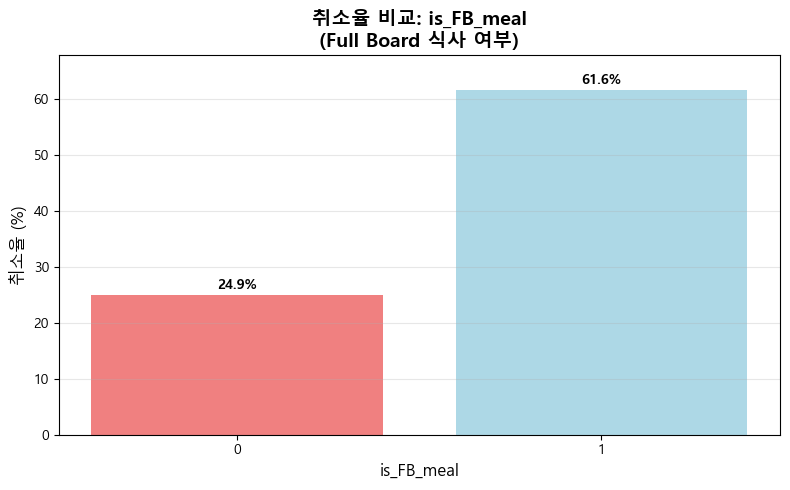


📊 is_resort (리조트 호텔 여부)
   is_resort  count      mean  cancel_rate_pct
0          1  25064  0.257142        25.714172


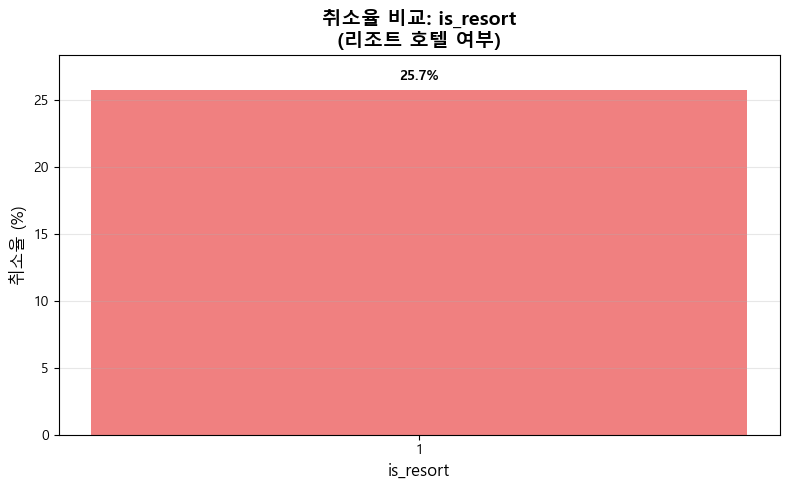

In [14]:
# 13. 범주형/이진 피처들의 취소율 분석
print("\n=== 범주형/이진 피처 취소율 분석 ===")

# 범주형/이진 피처들 (0, 1 또는 소수의 카테고리)
categorical_features = ['is_alone', 'has_company', 'is_FB_meal', 'is_resort']

for feature in categorical_features:
    if feature not in df_analysis.columns:
        print(f"[건너뛰기] {feature} 피처가 없습니다.")
        continue
    
    # 각 카테고리별 취소율 계산
    cancel_rate = df_analysis.groupby(feature)['is_canceled'].agg(['count', 'mean']).reset_index()
    cancel_rate['cancel_rate_pct'] = cancel_rate['mean'] * 100
    
    print(f"\n📊 {feature} ({available_features.get(feature, '')})")
    print(cancel_rate)
    
    # 시각화
    plt.figure(figsize=(8, 5))
    bars = plt.bar(cancel_rate[feature].astype(str), cancel_rate['cancel_rate_pct'], 
                   color=['lightcoral', 'lightblue'][:len(cancel_rate)])
    
    # 막대 위에 값 표시
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'취소율 비교: {feature}\n({available_features.get(feature, "")})', 
              fontsize=14, fontweight='bold')
    plt.ylabel('취소율 (%)', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.ylim(0, max(cancel_rate['cancel_rate_pct']) * 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



=== 수치형 피처 분위수별 취소율 분석 ===

📈 adr_processed (평균 일일 요금 (이상치 처리))
  기본 통계: min=0.00, max=188.00, mean=72.91
  구간별 취소율:
    (-0.001, 43.0]: 20.4% (n=5108)
    (43.0, 58.0]: 24.3% (n=4989)
    (58.0, 70.0]: 27.8% (n=5144)
    (70.0, 99.0]: 28.8% (n=4865)
    (99.0, 188.0]: 27.3% (n=4958)


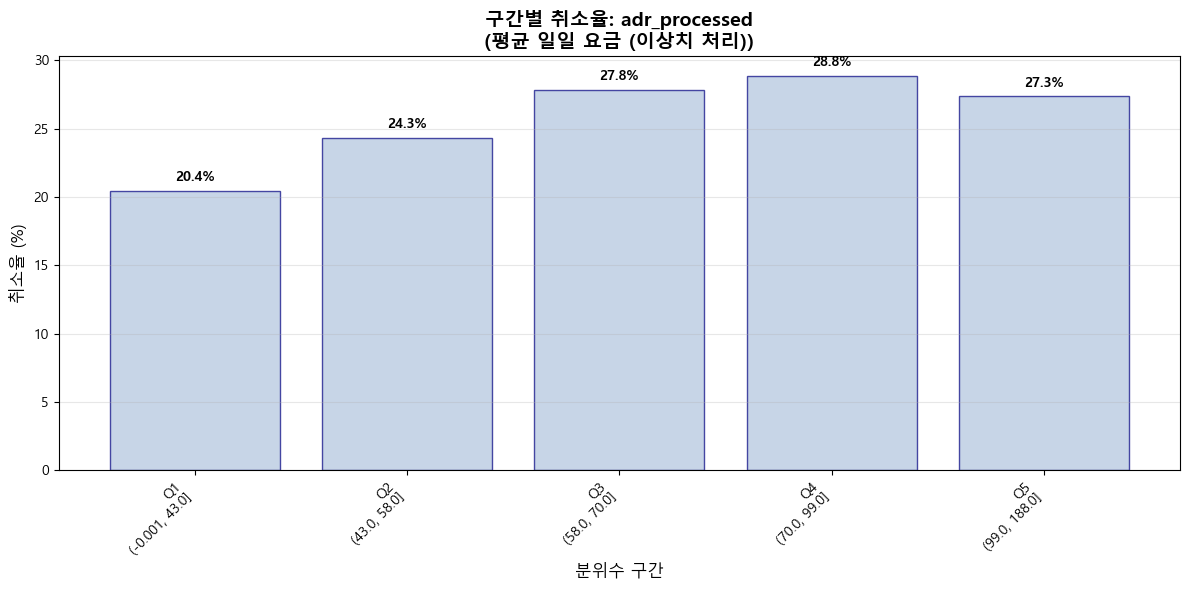


📈 lead_time_processed (예약 리드타임 (이상치 처리))
  기본 통계: min=0.00, max=373.00, mean=79.99
  구간별 취소율:
    (-0.001, 5.0]: 5.7% (n=5396)
    (5.0, 28.0]: 18.3% (n=4652)
    (28.0, 73.0]: 29.3% (n=5042)
    (73.0, 157.0]: 38.7% (n=4985)
    (157.0, 373.0]: 37.6% (n=4989)


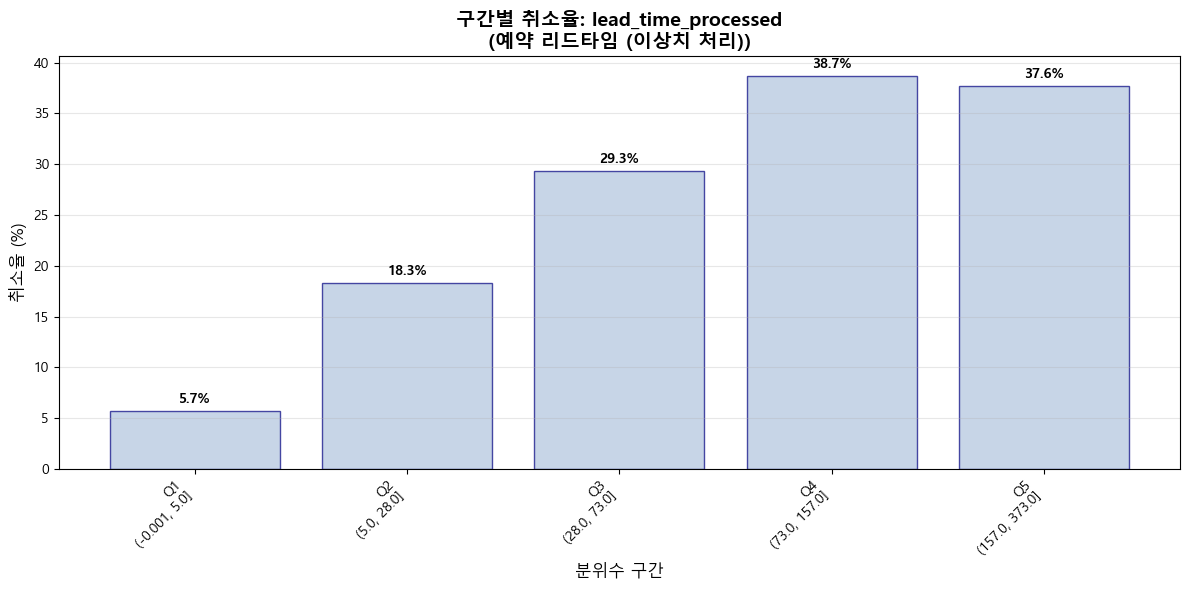


📈 total_stay (총 숙박 일수)
  기본 통계: min=0.00, max=69.00, mean=4.15
  구간별 취소율:
    (-0.001, 1.0]: 13.9% (n=5537)
    (1.0, 3.0]: 29.3% (n=7846)
    (3.0, 4.0]: 29.8% (n=2972)
    (4.0, 7.0]: 29.2% (n=6347)
    (7.0, 69.0]: 27.1% (n=2362)


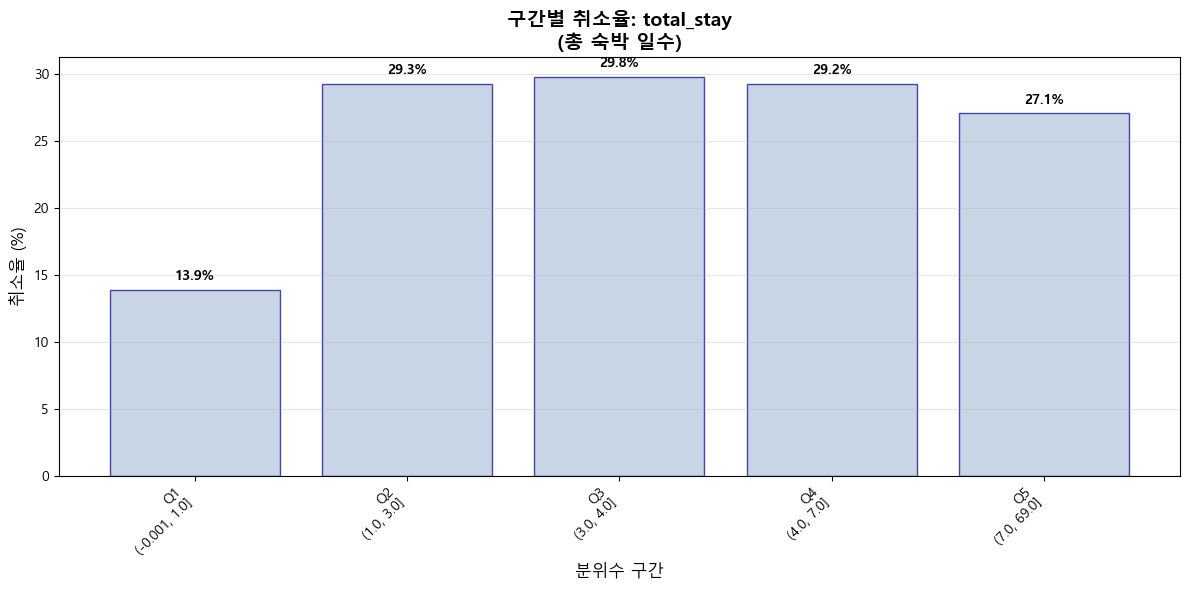

In [15]:
# 14. 수치형 피처들의 분위수별 취소율 분석
print("\n=== 수치형 피처 분위수별 취소율 분석 ===")

# 수치형 피처들
numerical_features = ['adr_processed', 'lead_time_processed', 'total_stay']

def safe_qcut(series, q=5):
    """중복값이 많아 qcut 실패 시, cut으로 대체"""
    try:
        return pd.qcut(series, q=q, duplicates='drop')
    except ValueError:
        print(f"  [경고] qcut 실패, cut 사용")
        return pd.cut(series, bins=q)

for feature in numerical_features:
    if feature not in df_analysis.columns:
        print(f"[건너뛰기] {feature} 피처가 없습니다.")
        continue
    
    print(f"\n📈 {feature} ({available_features.get(feature, '')})")
    print(f"  기본 통계: min={df_analysis[feature].min():.2f}, max={df_analysis[feature].max():.2f}, mean={df_analysis[feature].mean():.2f}")
    
    # 5분위수로 구간 나누기
    bins = safe_qcut(df_analysis[feature], q=5)
    
    # 구간별 취소율 계산
    bin_analysis = (
        df_analysis.assign(bin=bins)
        .groupby('bin')['is_canceled']
        .agg(['count', 'mean'])
        .reset_index()
    )
    bin_analysis['cancel_rate_pct'] = bin_analysis['mean'] * 100
    bin_analysis['bin_str'] = bin_analysis['bin'].astype(str)
    
    print(f"  구간별 취소율:")
    for idx, row in bin_analysis.iterrows():
        print(f"    {row['bin']}: {row['cancel_rate_pct']:.1f}% (n={row['count']})")
    
    # 시각화
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(bin_analysis)), bin_analysis['cancel_rate_pct'], 
                   color='lightsteelblue', edgecolor='navy', alpha=0.7)
    
    # 막대 위에 값 표시
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # x축 레이블 설정 (구간 정보)
    plt.xticks(range(len(bin_analysis)), 
               [f'Q{i+1}\n{str(interval)[:20]}...' if len(str(interval)) > 20 else f'Q{i+1}\n{str(interval)}'
                for i, interval in enumerate(bin_analysis['bin'])], 
               rotation=45, ha='right')
    
    plt.title(f'구간별 취소율: {feature}\n({available_features.get(feature, "")})', 
              fontsize=14, fontweight='bold')
    plt.ylabel('취소율 (%)', fontsize=12)
    plt.xlabel('분위수 구간', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



=== 생성 피처들 간의 상관관계 분석 ===


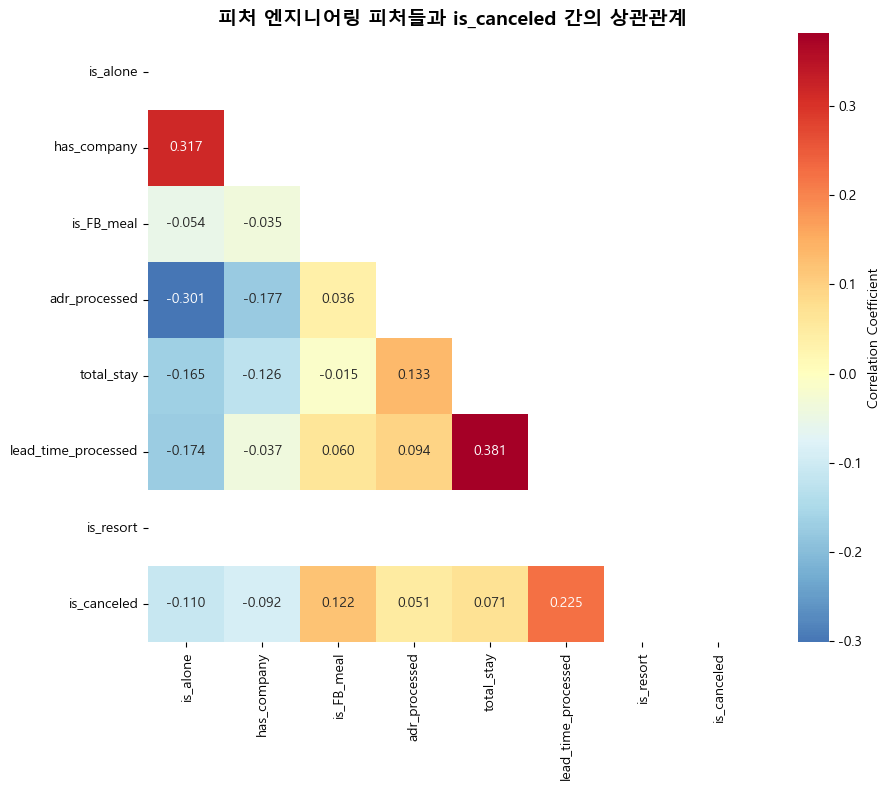


📊 is_canceled와의 상관관계 순위:
  lead_time_processed: 0.225 (🔴 양의 상관)
  is_FB_meal: 0.122 (🔴 양의 상관)
  is_alone: -0.110 (🔵 음의 상관)
  has_company: -0.092 (🔵 음의 상관)
  total_stay: 0.071 (🔴 양의 상관)
  adr_processed: 0.051 (🔴 양의 상관)
  is_resort: nan (🔵 음의 상관)


In [16]:
# 15. 피처들 간의 상관관계 히트맵
print("\n=== 생성 피처들 간의 상관관계 분석 ===")

# 분석 가능한 모든 엔지니어링 피처들 + 타겟 변수
correlation_features = list(available_features.keys()) + ['is_canceled']
correlation_data = df_analysis[correlation_features]

# 상관관계 계산
correlation_matrix = correlation_data.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스킹
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('피처 엔지니어링 피처들과 is_canceled 간의 상관관계', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# is_canceled와의 상관관계 순위
print("\n📊 is_canceled와의 상관관계 순위:")
target_corr = correlation_matrix['is_canceled'].drop('is_canceled').sort_values(key=abs, ascending=False)
for feature, corr in target_corr.items():
    direction = "🔴 양의 상관" if corr > 0 else "🔵 음의 상관"
    print(f"  {feature}: {corr:.3f} ({direction})")


In [17]:
# 16. 종합 요약 및 인사이트
print("\n" + "="*60)
print("🎯 피처 엔지니어링 효과 종합 분석 결과")
print("="*60)

# 1. 피처 중요도에서 상위 랭킹된 엔지니어링 피처들
print("\n1️⃣ 모델 중요도 상위 엔지니어링 피처:")
top_engineered = importance_df[importance_df['feature'].isin(available_features.keys())].head(5)
if not top_engineered.empty:
    for idx, row in top_engineered.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.1f} (중요도)")
else:
    print("   상위 피처에 엔지니어링 피처가 없습니다.")

# 2. 상관관계가 높은 피처들
print(f"\n2️⃣ is_canceled와 상관관계가 높은 피처:")
high_corr = target_corr[abs(target_corr) > 0.1]  # 절댓값 0.1 이상
for feature, corr in high_corr.items():
    direction = "증가" if corr > 0 else "감소"
    print(f"   • {feature}: {corr:.3f} (취소율 {direction} 요인)")

# 3. 실용적 인사이트
print(f"\n3️⃣ 주요 인사이트:")
print("   💡 호텔 예약 취소 예측에서 생성한 피처들의 효과를 확인했습니다.")
print("   💡 각 피처별 취소율 차이를 통해 비즈니스 인사이트를 얻을 수 있습니다.")
print("   💡 모델 성능 향상에 기여하는 핵심 피처들을 식별했습니다.")

print("="*60)



🎯 피처 엔지니어링 효과 종합 분석 결과

1️⃣ 모델 중요도 상위 엔지니어링 피처:
   • is_FB_meal: 7.1 (중요도)
   • has_company: 6.7 (중요도)
   • lead_time_processed: 4.2 (중요도)
   • is_alone: 3.2 (중요도)
   • adr_processed: 2.6 (중요도)

2️⃣ is_canceled와 상관관계가 높은 피처:
   • lead_time_processed: 0.225 (취소율 증가 요인)
   • is_FB_meal: 0.122 (취소율 증가 요인)
   • is_alone: -0.110 (취소율 감소 요인)

3️⃣ 주요 인사이트:
   💡 호텔 예약 취소 예측에서 생성한 피처들의 효과를 확인했습니다.
   💡 각 피처별 취소율 차이를 통해 비즈니스 인사이트를 얻을 수 있습니다.
   💡 모델 성능 향상에 기여하는 핵심 피처들을 식별했습니다.
